cluster_demographics
-------------------

This notebook produces figures 5 - 8 of the review Krumholz, McKee, & Bland-Hawthorn (2019, ARA&A, submitted). It operates on the data files `cmf_data_compilation.txt`, `gcmf_data_compilation.txt`, `caf_data_compilation.txt`, and `gamma_data_compilation.txt`, and `piskunov2018_caf.txt`, all included in this repository. All of these files except the last one are our compilations from the literature; see files for full references and explanatory notes. The file `piskunov20118_caf.txt` is a recent measurement of the cluster age function from [Piskunov et al., 2018, A&A, 614, A22](http://adsabs.harvard.edu/abs/2018A%26A...614A..22P), and was provided by N. Kharchenko.

In [1]:
# Make plots inline
%matplotlib inline

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import os.path as osp
from astropy.io import ascii as asciitab
from scipy.interpolate import splrep, splev
from scipy.optimize import curve_fit
from astropy.convolution import convolve, Box1DKernel

In [3]:
# Read the data compilation on the CMF
cmfdat = asciitab.read(osp.join('data', 'cmf_data_compilation.txt'))
ndat = len(cmfdat['Galaxy_Name'])

In [4]:
# Get indices that correspond to whole-galaxy averages
# and to independent sub-samples; note that the sub-
# sample list includes both independent sub-samples of
# galaxies in the "all" list, AND members of the "all"
# list for which there are no sub-samples, so there is
# some overlap between the lists
idx_all = np.array([i for i in range(ndat) 
                    if "_" not in cmfdat["Galaxy_Name"][i]])
idx_sub = [i for i in range(ndat) 
           if "_" in cmfdat["Galaxy_Name"][i]]
for i in idx_all:
    if i == ndat-1: continue
    if not cmfdat["Galaxy_Name"][i+1].\
        startswith(cmfdat["Galaxy_Name"][i]+"_"):
        idx_sub.append(i)
idx_sub = np.array(idx_sub)

# Sort all sample by lower mass limit to faciltate plotting
m_lo = np.array([cmfdat['M_lo'][i] for i in idx_all])
idx_all = idx_all[np.argsort(m_lo)]

In [5]:
# Function that returns alpha_M for an evolved Schechter
# mass function, following Jordan et al., 2007, ApJS,
# 171, 101
def alphaM_es(M, Mc, Delta):
    return -M*(M + 2.0*Mc + Delta) / (Mc*(M+Delta))

In [6]:
# Read GCMF compilation; compute average parameters for
# Virgo sample
gcmfdat = asciitab.read(osp.join('data', 'gcmf_data_compilation.txt'))
gcmf_Virgo_Mc = np.mean([g['Mc'] for g in gcmfdat if g['Bin'] != 'MW'])
gcmf_Virgo_Delta = np.mean([g['Delta'] for g in gcmfdat if g['Bin'] != 'MW'])

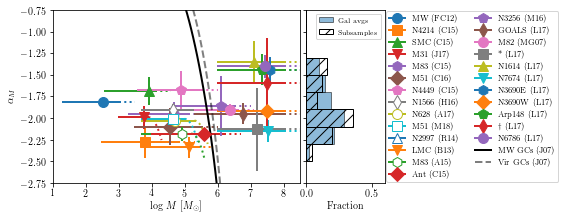

In [7]:
# Make summary plot of mass function measurements
plt.figure(1, figsize=(8,3))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Control parameters
lw=2
ms=10
shapes = ['o', 's', '^', 'v', 'h', 'D', 'p', 'd']

# Main panel
gs = gridspec.GridSpec(1, 6)
ax = plt.subplot(gs[0, :-3])
ylim = [-2.75, -0.75]

# Loop over measurements
handles = []
for i, idx in enumerate(idx_all):
    
    # Set color and marker shape
    clr = 'C{:d}'.format(i % 10)
    marker = shapes[i % len(shapes)]
    
    # Plot alpha_M over mass range covered by observation
    mrange = np.array([cmfdat['M_lo'][idx], cmfdat['M_b'][idx]])
    plt.plot(mrange, np.ones(2)*cmfdat['alphaM'][idx],
             color=clr, lw=lw)
    
    # Add marker, filled for inclusive, open for exclusive
    if cmfdat['Exclusive'][idx]:
        mfc='w'
    else:
        mfc=clr
    offset = 0.6*np.random.rand()
    p,=plt.plot(np.mean(mrange) + offset,
                #0.05*(i-len(idx_all)//2),
                [cmfdat['alphaM'][idx]],
                mec=clr, mfc=mfc, marker=marker, ms=ms,
                mew=1, color=clr, lw=lw, zorder=100,
                label="{:s} ({:s})".format(
                    cmfdat['Galaxy_Name'][idx]
                    .replace('NGC0', 'NGC')
                    .replace('NGC', 'N')
                    .replace('UGC09618NED02', '*')
                    .replace('IRAS20351+2521', r'$\dagger$')
                    .replace('Antennae', 'Ant'),
                    cmfdat['Source'][idx])
               )
    handles.append(p)
        
    # Add error bars
    plt.plot(np.mean(mrange)*np.ones(2) + offset,
             cmfdat['alphaM'][idx] + 
             np.array([-1,1])*cmfdat['alphaM_err'][idx],
             lw=lw, color=clr)
    
    # Add symbol on the end to indicate if the upper limit is
    # the maximum mass in the sample (for pure powerlaw fits)
    # or is a fitted maximum/truncation mass
    if cmfdat['M_b_err'][idx] == '--':
        plt.plot(cmfdat['M_b'][idx] + np.array([0,0.5]),
                 cmfdat['alphaM'][idx]*np.ones(2), ':',
                 lw=lw, color=clr)
    else:
        plt.plot(cmfdat['M_b'][idx] + np.linspace(0,0.4),
                 cmfdat['alphaM'][idx] * np.exp(np.linspace(0,0.5)**2/(2.*1.**2)),
                 ':', lw=lw, color=clr)
        
# Add curve for MW GC's; the mass range here is the mass
# range covered by Jordan et al.'s Milky Way GC cluster
# sample, as read off their plot
Mgc = np.logspace(3.3, 6.3)
idx = list(gcmfdat['Bin']).index('MW')
p,=plt.plot(np.log10(Mgc), 
            alphaM_es(Mgc, 
                      10.**gcmfdat['Mc'][idx], 
                      10.**gcmfdat['Delta'][idx]),
            'k', lw=lw, label='MW GCs (J07)')
handles.append(p)

# Add other GCs; note that the mass range here is very
# approximate, since each of the Jordan et al. bins is
# an average over several galaxies with slightly different
# maximum masses and magnitude limits
Mgc = np.logspace(4, 6.5)
p,=plt.plot(np.log10(Mgc), 
            alphaM_es(Mgc, 10.**gcmf_Virgo_Mc, 10.**gcmf_Virgo_Delta),
            'k--', lw=lw, alpha=0.5, label='Vir GCs (J07)')
handles.append(p)


# Add labels
plt.xlabel(r'$\log\,M$ [$M_\odot$]')
plt.ylabel(r'$\alpha_M$')

# Adjust limits
plt.xlim([1,8.5])
plt.ylim(ylim)

# Flanking histogram
ax = plt.subplot(gs[0, -3])
bw = 0.2
nb = int(2/bw)
alpha_hist, hist_edge \
    = np.histogram(cmfdat['alphaM'][idx_sub], 
                   bins=-2.5+bw*np.arange(nb+1))
ax.barh(-2.5+bw*np.arange(nb), 
        alpha_hist/float(len(idx_sub)), 
        bw*np.ones(nb), align='edge',
        facecolor='C0',
        edgecolor='k',
        alpha=0.5)
alpha_hist, hist_edge \
    = np.histogram(cmfdat['alphaM'][idx_all], 
                   bins=-2.5+bw*np.arange(nb+1))
ax.barh(-2.5+bw*np.arange(nb), 
        alpha_hist/float(len(idx_all)), 
        bw*np.ones(nb), align='edge',
        facecolor='none',
        edgecolor='k',
        hatch='//')

# Add legend
circ1 = mpatches.Patch(fc='C0', ec='k', alpha=0.5, label='Gal avgs')
circ2 = mpatches.Patch(fc='none', ec='k', hatch='//', label='Subsamples')
ax.legend(handles = [circ1,circ2], prop={"size":7})

# Adjust limits and labels
plt.xlim([0,0.6])
plt.ylim(ylim)
ax.set_yticklabels([])
ax.set_xlabel('Fraction')

# Panel to hold the legend
ax = plt.subplot(gs[0, -2:])
plt.axis('off')
plt.legend(handles=handles, ncol=2, loc='center', prop={"size":8})

# Adjust margins
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.97, top=0.95, wspace=0.08)

# Save
plt.savefig(osp.join('figures', 'cmf.pdf'))

In [8]:
# Read the data compilation on the CAF
cafdat = asciitab.read(osp.join('data', 'caf_data_compilation.txt'), delimiter='\t')
ndat = len(cafdat['Galaxy_Name'])

In [9]:
# Sort the CAF data into a form that is easier to use for plotting;
# we want to make lists of grouped by exclusive vs inclusive catalog,
# and with sub-regions of a single galaxy grouped
cafgals = []
i = 0
while i < ndat:
    
    # Get name of this galaxy and the source
    galname = cafdat['Galaxy_Name'][i].split('_')[0]
    source = cafdat['Source'][i]
    
    # Create the first sub-region holder for it
    subreg = []
    subreg_name = cafdat['Galaxy_Name'][i]
    subreg_alphaT = [cafdat['alphaT'][i]]
    subreg_alphaT_err = [cafdat['alphaT_err'][i]]
    subreg_Tpts = [cafdat['T_lo'][i], cafdat['T_hi'][i]]
    
    # Loop through next entries in list
    j = i+1
    while j < ndat:
        
        # Is this entry for the same galaxy? If not,
        # end the subsample, end the loop, and move on
        galname_j = cafdat['Galaxy_Name'][j].split('_')[0]
        if galname_j != galname:
            subreg.append({
                'name' : subreg_name,
                'alphaT' : subreg_alphaT,
                'alphaT_err' : subreg_alphaT_err,
                'Tpts' : subreg_Tpts
            })
            break
            
        # If we're here, this entry is for the same
        # galaxy. Now check if it's for the same subregion.
        subreg_name_j = cafdat['Galaxy_Name'][j]
        if subreg_name_j == subreg_name:
            
            # This entry is for the same sub-region, so
            # just add to the point list
            subreg_Tpts.append(cafdat['T_hi'][j])
            subreg_alphaT.append(cafdat['alphaT'][j])
            subreg_alphaT_err.append(cafdat['alphaT_err'][j])
            
        else:
            
            # This entry is for a new sub-region of this
            # galaxy. End the current sub-region, append
            # it to the master sub-region list, then use
            # the data in this entry to start a new sub-region
            subreg.append({
                'name' : subreg_name,
                'alphaT' : subreg_alphaT,
                'alphaT_err' : subreg_alphaT_err,
                'Tpts' : subreg_Tpts
            })
            subreg_name = cafdat['Galaxy_Name'][j]
            subreg_alphaT = [cafdat['alphaT'][j]]
            subreg_alphaT_err = [cafdat['alphaT_err'][j]]
            subreg_Tpts = [cafdat['T_lo'][j], cafdat['T_hi'][j]]
            
        # Increment counter
        j = j+1
        
    # We're now done with this galaxy; append it to the 
    # master list
    cafgals.append({ 'name' : galname, 
                     'source' : source,
                     'subsamples' : subreg,
                     'exclusive' : cafdat['Exclusive'][i]})
        
    # Move counter
    i = j
    
# Sort to put exclusive catalogs first, and then order by alpha_T
cafgals.sort(key=lambda x: (x['exclusive'], x['subsamples'][0]['alphaT']), reverse=True)
nexclusive = np.sum([c['exclusive'] for c in cafgals])

In [10]:
# Make histograms of age function slopes, binned various ways

# Set up bins
bw = 0.25
nb = int(1.5/bw)
bins = -1.5 + bw*np.arange(nb+1)

# All measurements
alphaT_hist_all, edges \
    = np.histogram(cafdat['alphaT'], bins=bins)

# Broken down by exclusive vs inclusive catalog at ages < 10^8 yr
idx = np.logical_and(cafdat['Exclusive'], cafdat['T_lo'] < 8.0)
alphaT_hist_exclusive, edges \
    = np.histogram(cafdat['alphaT'][idx],
                   bins=bins)
idx = np.logical_and(np.logical_not(cafdat['Exclusive']),
                     cafdat['T_lo'] < 8.0)
alphaT_hist_inclusive, edges \
    = np.histogram(cafdat['alphaT'][idx],
                   bins=bins)

# Exclusive at ages >= 10^8 yr
idx = np.logical_and(cafdat['Exclusive'], cafdat['T_lo'] >= 8.0)
alphaT_hist_exclusive_old, edges \
    = np.histogram(cafdat['alphaT'][idx],
                   bins=bins)

In [11]:
# Read the Piskunov et al. CAF for the Solar neighborhood;
# make a smoothed basis spline fit to it
caf_local = asciitab.read(osp.join('data', 'piskunov2018_caf.txt'))
caf_spl = splrep(np.array(caf_local['log_T']), 
                 np.array(caf_local['dN_dT']),
                 w=1.0/np.array(caf_local['dN_dT_err']),
                 s=350)

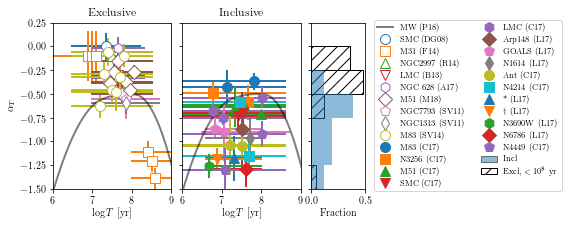

In [12]:
# Make plot
plt.figure(1, figsize=(8,3))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Control parameters
lw=2
ms=10
shapes = ['o', 's', '^', 'v', 'h', 'D', 'p', 'd']
ylim = [-1.5, 0.25]

# Set up plotting layout
gs = gridspec.GridSpec(1, 8)

# First window
ax = plt.subplot(gs[0, :2])

# Plot exclusive data
ctr = 0
labels = []
handles = []
for i, s in enumerate(cafgals[:nexclusive]):
    
    # Set color and symbol
    clr = 'C{:d}'.format(ctr % 10)
    sh = shapes[ctr % len(shapes)]
    if s['exclusive']:
        mfc = 'w'
    else:
        mfc = clr
    ctr += 1
    
    # Loop over sub-samples
    for j, ss in enumerate(s['subsamples']):
        
        # Plot points
        for k in range(len(ss['Tpts'])-1):
            
            x = np.array(ss['Tpts'][k:k+2])
            plt.plot(x, ss['alphaT'][k]*np.ones(2), color=clr, lw=lw)
            xpt = np.mean(x)+0.1*(j-len(s['subsamples'])//2)
            p,=plt.plot(xpt, [ss['alphaT'][k]], sh,
                        mfc=mfc, mec=clr, ms=ms, mew=1, zorder=100)
            plt.plot([xpt, xpt],
                     ss['alphaT'][k]+np.array([-1,1])*ss['alphaT_err'][k],
                     color=clr, lw=lw)
            if j == 0 and k == 0:
                handles.append(p)
                labels.append('{:s} ({:s})'.format(
                    s['name'].replace('0', ' '), s['source']))
                
# Add Milky Way line
x = np.linspace(caf_local['log_T'][0], caf_local['log_T'][-1])
p, = plt.plot(x, splev(x, caf_spl, der=1), 'k', lw=lw, alpha=0.5)
handles = [p] + handles
labels = ['MW (P18)'] + labels

# Fix plot range and labels
plt.xlim([6, 9])
plt.ylim(ylim)
plt.xlabel(r'$\log T$ [yr]')
plt.ylabel(r'$\alpha_T$')

# Add legend and title
#plt.legend(handles, labels, loc='lower left', prop={"size":8})
plt.title('Exclusive')

# Second window
ax = plt.subplot(gs[0, 2:4])

# Plot inclusive data
ctr = 0
labels_in = []
handles_in = []
for i, s in enumerate(cafgals[nexclusive:]):
    
    # Set color and symbol
    clr = 'C{:d}'.format(ctr % 10)
    sh = shapes[ctr % len(shapes)]
    if s['exclusive']:
        mfc = 'w'
    else:
        mfc = clr
    ctr += 1
    
    # Loop over sub-samples
    for j, ss in enumerate(s['subsamples']):
        
        # Plot points and erro bars
        for k in range(len(ss['Tpts'])-1):
            
            x = np.array(ss['Tpts'][k:k+2])
            plt.plot(x, ss['alphaT'][k]*np.ones(2), color=clr, lw=lw)
            xpt = np.mean(x)+np.random.rand()*1.5-0.75
            p,=plt.plot([xpt], 
                        [ss['alphaT'][k]], sh,
                        mfc=mfc, mec=clr, ms=ms, mew=1, zorder=100)
            plt.plot([xpt, xpt],
                     ss['alphaT'][k]+np.array([-1,1])*ss['alphaT_err'][k],
                     color=clr, lw=lw)
            
            if j == 0 and k == 0:
                handles_in.append(p)
                labels_in.append('{:s} ({:s})'.format(
                    s['name']
                    .replace('NGC0', 'NGC')
                    .replace('NGC', 'N')
                    .replace('UGC09618NED02', '*')
                    .replace('IRAS20351+2521', r'$\dagger$')
                    .replace('Antennae', 'Ant'), s['source']))
                
# Add Milky Way line
x = np.linspace(caf_local['log_T'][0], caf_local['log_T'][-1])
p, = plt.plot(x, splev(x, caf_spl, der=1), 'k', lw=lw, alpha=0.5)

# Fix plot range
plt.xlim([6, 9])
plt.ylim(ylim)
plt.xlabel(r'$\log T$ [yr]')
plt.gca().set_yticklabels([])

# Add legend and title
#plt.legend(handles, labels, ncol=3, loc='upper right', prop={"size":8})
plt.title('Inclusive')

# Third window
ax = plt.subplot(gs[0, 4])

# Make bar plots
plt.barh(bins[:-1],
         alphaT_hist_exclusive/float(np.sum(alphaT_hist_exclusive)), 
         bw*np.ones(nb),
         align='edge', hatch='//', fc='none', ec='k')
plt.barh(bins[:-1], 
         alphaT_hist_inclusive/float(np.sum(alphaT_hist_inclusive)),
         bw*np.ones(nb),
         align='edge', fc='C0', alpha=0.5)

# Add legend
circ1 = mpatches.Patch(fc='C0', ec='k', alpha=0.5, label='Incl')
circ2 = mpatches.Patch(fc='none', ec='k', hatch='//', label='Excl, $<10^8$ yr')
handles_hist = [circ1,circ2]
labels_hist = ['Incl', 'Excl, $<10^8$ yr']

# Adjust axis range, set labels
plt.ylim(ylim)
plt.gca().set_yticklabels([])
plt.xlabel('Fraction')

# Panel to hold the legend
ax = plt.subplot(gs[0, -3:])
plt.axis('off')
plt.legend(handles+handles_in+handles_hist, 
           labels+labels_in+labels_hist, ncol=2, 
           loc='center', prop={"size":8})


# Adjust spacing
plt.subplots_adjust(left=0.1, bottom=0.15, top=0.92, right=0.98)

# Save
plt.savefig(osp.join('figures', 'caf.pdf'))

In [13]:
# Read compilation of Gamma's
gammadat = asciitab.read(osp.join('data', 'gamma_data_compilation.txt'), delimiter='\t')
ndat = len(gammadat)

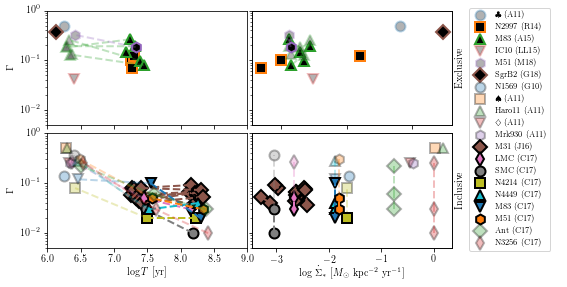

In [14]:
# Make plot
plt.figure(1, figsize=(8,4))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Control parameters
lw=2
ms=10
shapes = ['o', 's', '^', 'v', 'h', 'D', 'd']
ylim = [5e-3, 1]
alpha_low = 0.3

# Set up plotting layout
gs = gridspec.GridSpec(2, 5)

# First window: Gamma vs age, exclusive catalogs
ax = plt.subplot(gs[0, :2])

# Loop over catalog entries
ctr = 0
ctr1 = 0
alpha = 1.0
handles = []
xvals = list(np.unique(np.round(0.5*(gammadat['T_lo']+gammadat['T_hi']), 1)))
nxvals = [ np.sum(np.round(0.5*(gammadat['T_lo']+gammadat['T_hi']), 1) == x) for x in xvals ]
xctr = np.zeros(len(xvals), dtype=int)
while ctr < ndat:
    
    # Skip inclusive catalogs
    if not gammadat['Exclusive'][ctr]:
        ctr += 1
        continue
    
    # Set color and symbol
    clr = 'C{:d}'.format(ctr1 % 10)
    sh = shapes[ctr1 % len(shapes)]
    if gammadat['Exclusive'][ctr]:
        mfc = 'none'
        mec = clr
    else:
        mfc = clr
        mec = clr
    
    # Loop over entries that are all this galaxy
    galname = gammadat['Galaxy_Name'][ctr].split('_')[0]
    i = 0
    while gammadat['Galaxy_Name'][i+ctr].split('_')[0] == galname:
                            
        # Flag if this entry is dubious because it's a starburst
        # at an old age, or it's a young catalog
        if (gammadat['T_lo'][i+ctr] > 6.5 and gammadat['SB'][i+ctr] == 1) or \
           (gammadat['T_lo'][i+ctr] <= 6.5):
            alpha = alpha_low
        else:
            alpha = 1.0
            
        # Exception for Sgr B2 point, because is has been checked by kinematics
        if galname == 'SgrB2': alpha=1.0
            
        # Get x coordinate; offset slightly to avoid overlapping errorbars
        dx = gammadat['T_hi'][i+ctr] - gammadat['T_lo'][i+ctr]
        x = 0.5*(gammadat['T_lo'][i+ctr]+gammadat['T_hi'][i+ctr])
        idx = xvals.index(np.round(x, 1))
        x += (xctr[idx]-0.5*nxvals[idx])*0.5*dx/nxvals[idx]
        xctr[idx] += 1
                
        # Plot point
        p,=plt.plot([x], [gammadat['Gamma'][i+ctr]], sh,
                    mfc=mfc, mec=mec, mew=lw, ms=ms, alpha=alpha,
                    #zorder=100,
                    label="{:s} ({:s})".format(
                        galname
                        .replace('NGC0', 'NGC')
                        .replace('NGC', 'N')
                        .replace('ESO185-IG13', r'$\diamondsuit$')
                        .replace('ESO338-IG04', r'$\spadesuit$')
                        .replace('SBS0335-052E', r'$\clubsuit$')
                        .replace('Antennae', 'Ant'),
                        gammadat['Source'][i+ctr]))
        if i == 1: handles.append(p)
                
        # If multiple points from the same region at different times, connect
        if i > 0:
            if (gammadat['T_lo'][i-1+ctr] > 6.5 and gammadat['SB'][i-1+ctr] == 1) or \
               (gammadat['T_lo'][i-1+ctr] <= 6.5):
                alpha = alpha_low
            if gammadat['T_hi'][i+ctr-1] == gammadat['T_lo'][i+ctr]:
                xprev = 0.5*(gammadat['T_lo'][i+ctr-1]+gammadat['T_hi'][i+ctr-1])
                dxprev = gammadat['T_hi'][i+ctr-1] - gammadat['T_lo'][i+ctr-1]
                idx = xvals.index(np.round(xprev, 1))
                xprev += (xctr[idx]-1-0.5*nxvals[idx])*0.5*dxprev/nxvals[idx]
                plt.plot([x,xprev], 
                         [gammadat['Gamma'][i+ctr], gammadat['Gamma'][i+ctr-1]],
                         lw=lw, ls='--', color=clr, alpha=alpha)

        # Increment counter
        i += 1
        if ctr+i == ndat: break
        
    # Increment ctr
    ctr += i
    ctr1 += 1

# Adjust scale and labels
plt.yscale('log')
plt.ylim(ylim)
plt.xlim([6,9])
plt.gca().set_xticklabels([])
plt.ylabel(r'$\Gamma$')



# Second window: Gamma vs Sigma_SFR
ax = plt.subplot(gs[0, 2:4])

# Loop through catalog
ctr = 0
ctr1 = 0
handles = []
while ctr < ndat:

    # Skip inclusive catalogs
    if not gammadat['Exclusive'][ctr]:
        ctr += 1
        continue
        
    # Set color and symbol
    clr = 'C{:d}'.format(ctr1 % 10)
    sh = shapes[ctr1 % len(shapes)]
    if gammadat['Exclusive'][ctr]:
        mfc = 'none'
        mec = clr
    else:
        mfc = clr
        mec = 'k'
    
    # Loop over entries that are all this galaxy
    galname = gammadat['Galaxy_Name'][ctr].split('_')[0]
    i = 0
    while gammadat['Galaxy_Name'][i+ctr].split('_')[0] == galname:
                
        # Flag if this entry is dubious because it's a starburst
        # at an old age
        if (gammadat['T_lo'][i+ctr] > 6.5 and gammadat['SB'][i+ctr] == 1) or \
           (gammadat['T_lo'][i+ctr] <= 6.5):
            alpha = alpha_low
        else:
            alpha = 1.0
            
        # Exception for Sgr B2 point, because is has been checked by kinematics
        if galname == 'SgrB2': alpha=1.0

        # Plot point
        p,=plt.plot([gammadat['Sigma_SFR'][i+ctr]], 
                    [gammadat['Gamma'][i+ctr]], sh,
                    ms=ms, mfc=mfc, mec=mec, mew=lw, alpha=alpha,
                    #zorder=100,
                    label="{:s} ({:s})".format(
                        galname
                        .replace('NGC0', 'NGC')
                        .replace('NGC', 'N')
                        .replace('ESO185-IG13', r'$\diamondsuit$')
                        .replace('ESO338-IG04', r'$\spadesuit$')
                        .replace('SBS0335-052E', r'$\clubsuit$')
                        .replace('Antennae', 'Ant'),
                        gammadat['Source'][i+ctr]))
        if i == 0: handles.append(p)

        # If multiple points from the same region at different times, connect
        if i > 0:
            if (gammadat['T_lo'][i-1+ctr] > 6.5 and gammadat['SB'][i-1+ctr] == 1) or \
               (gammadat['T_lo'][i-1+ctr] <= 6.5):
                alpha = alpha_low
            if gammadat['T_hi'][i+ctr-1] == gammadat['T_lo'][i+ctr]:
                plt.plot([gammadat['Sigma_SFR'][i+ctr], gammadat['Sigma_SFR'][i+ctr-1]],
                         [gammadat['Gamma'][i+ctr], gammadat['Gamma'][i+ctr-1]],
                         lw=lw, ls='--', color=clr, alpha=alpha)

        # Increment counter
        i += 1
        if ctr+i == ndat: break
        
    # Increment ctr
    ctr += i
    ctr1 += 1
    
# Adjust scale and labels 
plt.yscale('log')
plt.ylim(ylim)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.twinx()
plt.gca().set_yticks([])
plt.ylabel('Exclusive')

# Third window: Gamma vs age, inclusive catalogs
ax = plt.subplot(gs[1, :2])

# Loop over catalog entries
ctr = 0
ctr1 = 0
handles_in = []
xvals = list(np.unique(np.round(0.5*(gammadat['T_lo']+gammadat['T_hi']), 1)))
nxvals = [ np.sum(np.round(0.5*(gammadat['T_lo']+gammadat['T_hi']), 1) == x) for x in xvals ]
xctr = np.zeros(len(xvals), dtype=int)
while ctr < ndat:
    
    # Skip inclusive catalogs
    if gammadat['Exclusive'][ctr]:
        ctr += 1
        continue
    
    # Set color and symbol
    clr = 'C{:d}'.format(ctr1 % 10)
    sh = shapes[ctr1 % len(shapes)]
    if gammadat['Exclusive'][ctr]:
        mfc = 'none'
        mec = clr
    else:
        mfc = clr
        mec = 'k'
    
    # Loop over entries that are all this galaxy
    galname = gammadat['Galaxy_Name'][ctr].split('_')[0]
    i = 0
    while gammadat['Galaxy_Name'][i+ctr].split('_')[0] == galname:
            
        # Flag if this entry is dubious because it's a starburst
        # at an old age
        if (gammadat['T_lo'][i+ctr] > 6.5 and gammadat['SB'][i+ctr] == 1) or \
           (gammadat['T_lo'][i+ctr] <= 6.5):
            alpha = alpha_low
        else:
            alpha = 1.0

        # Get x coordinate; offset slightly to avoid overlapping errorbars
        dx = gammadat['T_hi'][i+ctr] - gammadat['T_lo'][i+ctr]
        x = 0.5*(gammadat['T_lo'][i+ctr]+gammadat['T_hi'][i+ctr])
        idx = xvals.index(np.round(x, 1))
        x += (xctr[idx]-0.5*nxvals[idx])*0.5*dx/nxvals[idx]
        xctr[idx] += 1
                
        # Plot point
        p,=plt.plot([x], [gammadat['Gamma'][i+ctr]], sh,
                    mfc=mfc, mec=mec, mew=lw, ms=ms, alpha=alpha,
                    #zorder=100,
                    label="{:s} ({:s})".format(
                        galname
                        .replace('NGC0', 'NGC')
                        .replace('NGC', 'N')
                        .replace('ESO185-IG13', r'$\diamondsuit$')
                        .replace('ESO338-IG04', r'$\spadesuit$')
                        .replace('SBS0335-052E', r'$\clubsuit$')
                        .replace('Antennae', 'Ant'),
                        gammadat['Source'][i+ctr]))
        if i == 0: handles_in.append(p)
                
        # If multiple points from the same region at different times, connect
        if i > 0:
            if (gammadat['T_lo'][i-1+ctr] > 6.5 and gammadat['SB'][i-1+ctr] == 1) or \
               (gammadat['T_lo'][i-1+ctr] <= 6.5):
                alpha = alpha_low
            if gammadat['T_hi'][i+ctr-1] == gammadat['T_lo'][i+ctr]:
                xprev = 0.5*(gammadat['T_lo'][i+ctr-1]+gammadat['T_hi'][i+ctr-1])
                dxprev = gammadat['T_hi'][i+ctr-1] - gammadat['T_lo'][i+ctr-1]
                idx = xvals.index(np.round(xprev, 1))
                xprev += (xctr[idx]-1-0.5*nxvals[idx])*0.5*dxprev/nxvals[idx]
                plt.plot([x,xprev], 
                         [gammadat['Gamma'][i+ctr], gammadat['Gamma'][i+ctr-1]],
                         lw=lw, ls='--', color=clr, alpha=alpha)

        # Increment counter
        i += 1
        if ctr+i == ndat: break
        
    # Increment ctr
    ctr += i
    ctr1 += 1

# Adjust scale and labels
plt.yscale('log')
plt.ylim(ylim)
plt.xlim([6,9])
plt.xlabel(r'$\log T$ [yr]')
plt.ylabel(r'$\Gamma$')


# Fourth window: Gamma vs Sigma_SFR, inclusive
ax = plt.subplot(gs[1, 2:4])

# Loop thorugh catalog
ctr = 0
ctr1 = 0
handles_in = []
while ctr < ndat:

    # Skip inclusive catalogs
    if gammadat['Exclusive'][ctr]:
        ctr += 1
        continue
        
    # Set color and symbol
    clr = 'C{:d}'.format(ctr1 % 10)
    sh = shapes[ctr1 % len(shapes)]
    if gammadat['Exclusive'][ctr]:
        mfc = 'none'
        mec = clr
    else:
        mfc = clr
        mec = 'k'
    
    # Loop over entries that are all this galaxy
    galname = gammadat['Galaxy_Name'][ctr].split('_')[0]
    i = 0
    while gammadat['Galaxy_Name'][i+ctr].split('_')[0] == galname:
                
        # Flag if this entry is dubious because it's a starburst
        # at an old age, or an inclusive catalog at a young age
        if (gammadat['T_lo'][i+ctr] > 6.5 and gammadat['SB'][i+ctr] == 1) or \
           (gammadat['T_lo'][i+ctr] <= 6.5):
            alpha = alpha_low
        else:
            alpha = 1.0
            
        # Plot point
        p,=plt.plot([gammadat['Sigma_SFR'][i+ctr]], 
                    [gammadat['Gamma'][i+ctr]], sh,
                    ms=ms, mfc=mfc, mec=mec, mew=lw, alpha=alpha,
                    #zorder=100,
                    label="{:s} ({:s})".format(
                        galname
                        .replace('NGC0', 'NGC')
                        .replace('NGC', 'N')
                        .replace('ESO185-IG13', r'$\diamondsuit$')
                        .replace('ESO338-IG04', r'$\spadesuit$')
                        .replace('SBS0335-052E', r'$\clubsuit$')
                        .replace('Antennae', 'Ant'),
                        gammadat['Source'][i+ctr]))
        if i == 1: 
            handles_in.append(p)
        elif i == 0 and gammadat['Galaxy_Name'][i+1+ctr].split('_')[0] != galname: 
            handles_in.append(p)

        # If multiple points from the same region at different times, connect
        if i > 0:
            if (gammadat['T_lo'][i-1+ctr] > 6.5 and gammadat['SB'][i-1+ctr] == 1) or \
               (gammadat['T_lo'][i-1+ctr] <= 6.5):
                alpha = alpha_low
            if gammadat['T_hi'][i+ctr-1] == gammadat['T_lo'][i+ctr]:
                plt.plot([gammadat['Sigma_SFR'][i+ctr], gammadat['Sigma_SFR'][i+ctr-1]],
                         [gammadat['Gamma'][i+ctr], gammadat['Gamma'][i+ctr-1]],
                         lw=lw, ls='--', color=clr, alpha=alpha)

        # Increment counter
        i += 1
        if ctr+i == ndat: break
        
    # Increment ctr
    ctr += i
    ctr1 += 1
    
# Adjust scale and labels 
plt.yscale('log')
plt.ylim(ylim)
plt.xlabel(r'$\log\,\dot{\Sigma}_*$ [$M_\odot$ kpc$^{-2}$ yr$^{-1}$]')
plt.gca().set_yticklabels([])
plt.twinx()
plt.gca().set_yticks([])
plt.ylabel('Inclusive')

# Add legend
ax = plt.subplot(gs[:, 4])
plt.axis('off')
plt.legend(handles=handles+handles_in, ncol=1, loc='center right',
           prop={'size': 8})

# Adjust spacing
plt.subplots_adjust(wspace=0.05, top=0.95, left=0.1, hspace=0.07, right=0.98)

# Save
plt.savefig(osp.join('figures', 'gamma.pdf'))

In [15]:
# Fit the Piskunov+ 2018 Milky Way cluster data with various function forms

# List of functional forms to try; note that what we're fitting here is
# log(dN/dT), rather than dN/dT.
def dndt_fit_pl(logT, c, alphaT):
    return c + alphaT*logT
def dndt_fit_pl2(logT, c, alphaT1, alphaT2, logTb):
    logdNdT = np.zeros(logT.shape)
    idx = logT < logTb
    logdNdT[idx] = c + alphaT1*logT[idx]
    idx = logT >= logTb
    logdNdT[idx] = c + alphaT1*logTb + alphaT2*(logT[idx]-logTb)
    return logdNdT
def dndt_fit_exp(logT, c, logTd):
    Td = 10.**logTd
    T = 10.**logT
    return c - T/Td
def dndt_fit_sch(logT, c, alphaT, logTstar):
    Tstar = 10.**logTstar
    T = 10.**logT
    return c + alphaT*logT - T/Tstar

# Shorthands to data
logT = caf_local['log_T']
logdNdT = caf_local['dN_dT']
logdNdTerr = caf_local['dN_dT_err']
idx = caf_local['log_T'] >= 5

# Do fits
fit_pl, cov_pl = curve_fit(dndt_fit_pl, logT[idx], logdNdT[idx], [1., -0.5], 
                           sigma=logdNdTerr[idx])
fit_pl2, cov_pl2 = curve_fit(dndt_fit_pl2, logT[idx], logdNdT[idx], [1., -0.5, -2., 8.5], 
                             sigma=logdNdTerr[idx])
fit_exp, cov_exp = curve_fit(dndt_fit_exp, logT[idx], logdNdT[idx], [1., 9.],
                             sigma=logdNdTerr[idx])
fit_sch, cov_sch = curve_fit(dndt_fit_sch, logT[idx], logdNdT[idx], [1., -0.5, 9.],
                             sigma=logdNdTerr[idx])

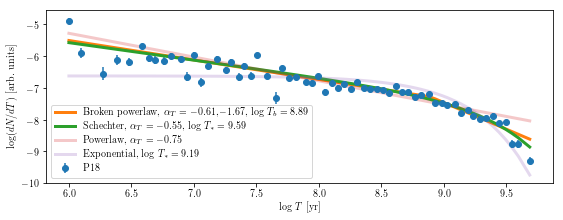

In [16]:
# Make plot of fits
plt.figure(1, figsize=(8,3))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.errorbar(logT, logdNdT-6, yerr=logdNdTerr, fmt='o', label='P18')
plt.plot(logT, dndt_fit_pl2(logT, fit_pl2[0], fit_pl2[1], fit_pl2[2], fit_pl2[3])-6, 
         lw=3,
         label='Broken powerlaw, $\\alpha_T={:4.2f}, {:4.2f}$, $\\log\\,T_b={:4.2f}$'.
         format(fit_pl2[1], fit_pl2[2], fit_pl2[3]))
plt.plot(logT, dndt_fit_sch(logT, fit_sch[0], fit_sch[1], fit_sch[2])-6,
         lw=3,
         label='Schechter, $\\alpha_T={:4.2f}$, $\\log\\,T_*={:4.2f}$'.
         format(fit_sch[1], fit_sch[2]))
plt.plot(logT, dndt_fit_pl(logT, fit_pl[0], fit_pl[1])-6, 
         lw=3, alpha=0.25,
         label='Powerlaw, $\\alpha_T={:4.2f}$'.format(fit_pl[1]))
plt.plot(logT, dndt_fit_exp(logT, fit_exp[0], fit_exp[1])-6,
         lw=3, alpha=0.25,
         label='Exponential, $\\log\\,T_*={:4.2f}$'.format(fit_exp[1]))
plt.legend()
plt.subplots_adjust(left=0.1, top=0.95, right=0.98, bottom=0.15)
plt.xlabel(r'$\log\,T$ [yr]')
plt.ylabel(r'$\log(dN/dT)$ [arb. units]')
plt.savefig(osp.join('figures', 'mw_age_dist.pdf'))